Check clipped-SSTM and clipped-SGD on BERT + STS-B task

In [1]:
from graph_plot_tools import *
from utils import *

In [2]:
import pandas as pd
data_folder_name = "glue_data"
df1 = pd.read_table("./{}/STS-B/train.tsv".format(data_folder_name), delimiter='\\t', )
df2 = pd.read_table("./{}/STS-B/dev.tsv".format(data_folder_name), delimiter='\\t', )
df = pd.concat([df1, df2]).rename(
    columns={
        'sentence1': 'sent1',
        'sentence2': 'sent2',
        'score': 'label',
    })
df['label'] = df['label'].astype('float32')
print("number of examples: ", df.shape[0])

num_labels = 1

df.head()

number of examples:  7249


/home/kesha/.local/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,index,genre,filename,year,old_index,source1,source2,sent1,sent2,label
0,0,main-captions,MSRvid,2012test,1,none,none,A plane is taking off.,An air plane is taking off.,5.00
1,1,main-captions,MSRvid,2012test,4,none,none,A man is playing a large flute.,A man is playing a flute.,3.80
2,2,main-captions,MSRvid,2012test,5,none,none,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,3.80
3,3,main-captions,MSRvid,2012test,6,none,none,Three men are playing chess.,Two men are playing chess.,2.60
4,4,main-captions,MSRvid,2012test,9,none,none,A man is playing the cello.,A man seated is playing the cello.,4.25


In [3]:
from transformers import BertTokenizer
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [4]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
# For every sentence...
for (sent1, sent2) in zip(df["sent1"].values, df["sent2"].values):
    sent = (sent1, sent2)
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        *sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)
# Print sentence 0, now as a list of IDs.
print('Original 1: ', df["sent1"].values[0])
print('Original 2: ', df["sent2"].values[0])
print('Token IDs:', input_ids[0])


Original 1:  A plane is taking off.
Original 2:  An air plane is taking off.
Token IDs: [101, 1037, 4946, 2003, 2635, 2125, 1012, 102, 2019, 2250, 4946, 2003, 2635, 2125, 1012, 102]


In [5]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))


Max sentence length:  125


In [6]:
# from keras.preprocessing.sequence import pad_sequences
def pad_sequences(seqs, maxlen=None, value=0, padding="post"):
    if maxlen is None:
        raise ValueError("Invalid maxlen: {}".format(maxlen))
    for i in range(len(seqs)):
        add = [value] * max(0, maxlen - len(seqs[i]))
        if padding == "post":
            seqs[i] = seqs[i] + add
        elif padding == "pre":
            seqs[i] = add + seqs[i]
    return seqs

MAX_LEN =  max([len(sen) for sen in input_ids])+1
print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, value=0, padding="post")
print('\Done.')


Padding/truncating all sentences to 126 values...

Padding token: "[PAD]", ID: 0
\Done.


In [7]:
# Create attention masks
attention_masks = []
# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

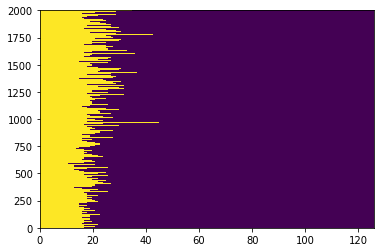

In [8]:
import matplotlib.pyplot as plt
plt.pcolor(attention_masks[0:2000])

In [9]:
df.label.values

array([5. , 3.8, 3.8, ..., 2. , 0. , 0. ], dtype=float32)

### Dataset train/val splits

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef

outer_constant = 13

data_split_rs = outer_constant

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids,
    df.label.values, 
    random_state=data_split_rs, 
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks, 
    df.label.values, 
    random_state=data_split_rs, 
    test_size=0.1
)

In [11]:
import torch
import scipy.stats
import matplotlib.pyplot as plt
import tqdm
import numpy as np

# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 2070 SUPER


In [12]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [13]:
random_seed = 1
num_workers = 1

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
###full_grad_dataloader
batch_size = 32 # train_inputs.shape[0]

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_loader_for_full_grad = DataLoader(
    train_data, batch_size=batch_size, num_workers=num_workers,
    worker_init_fn = lambda id: np.random.seed(id + num_workers * random_seed)
)


### for training
batch_size = 32 # train_inputs.shape[0]
# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_loader = DataLoader(
    train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers,
    worker_init_fn = lambda id: np.random.seed(id + num_workers * random_seed)
)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
val_loader = DataLoader(
    validation_data, batch_size=batch_size, shuffle=True, num_workers=num_workers,
    worker_init_fn = lambda id: np.random.seed(id + num_workers * random_seed)
)

### Tasks (models + optimizers)

In [14]:

# from transformers import BertForSequenceClassification
# BertForSequenceClassification.from_pretrained(
#     "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
#     num_labels = 2, # The number of output labels--2 for binary classification.
#                     # You can increase this for multi-class tasks.   
#     output_attentions = False, # Whether the model returns attentions weights.
#     output_hidden_states = False, # Whether the model returns all hidden-states.
# )

GLUE_TASKS = ["cola", "mnli", "mnli-mm", "mrpc", "qnli", "qqp", "rte", "sst2", "stsb", "wnli"]

task = "stsb" 

actual_task = "mnli" if task == "mnli-mm" else task 

from datasets import load_metric

metric = load_metric('glue', actual_task)

references = [0., 1., 2., 3., 4., 5.]
predictions = [0., 1., 2., 3., 4., 5.]
results = metric.compute(predictions=predictions, references=references)
metric_keys = results.keys()
metric_keys

dict_keys(['pearson', 'spearmanr'])

In [15]:
import torch.nn as nn
import torch.optim as optim

from transformers import BertForSequenceClassification

from optimizers import clipped_SGD, clipped_SSTM

nets = []

lrs = [1e-4, 1e-3, 1e-2]
# lrs = [1e-2, 3e-2]
# momentums = [0.98, 0.99, 0.995]
bs_muls_list = [2, 4, 8]
# batch_mul_step_count_list = [100, 200, 400]
# batch_mul_step_count_list = [50, 100, 200]

history_random_seed = outer_constant

# shift_mul = len(lrs) * len(bs_muls_list)
# shift_mul = len(lrs) * len(batch_mul_step_count_list)
shift_mul = 5

print("# of setups: {}".format(shift_mul))

starting_point_random_seed_shift = outer_constant * shift_mul

for starting_point_random_seed in range(5):
    for _ in range(starting_point_random_seed_shift, starting_point_random_seed_shift + shift_mul):
            # setting the same starting point for all algorithms
            torch.manual_seed(starting_point_random_seed)
            nets.append(
                BertForSequenceClassification.from_pretrained(
                    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
                    num_labels = num_labels, # The number of output labels--2 for binary classification.
                                    # You can increase this for multi-class tasks.   
                    output_attentions = False, # Whether the model returns attentions weights.
                    output_hidden_states = False, # Whether the model returns all hidden-states.
                )
            )

            nets[-1].zero_grad()
            for i, name_param in enumerate(nets[-1].named_parameters()):
                if i < 197: # 197 -- 2 linears, 199 - only last linear
                    name_param[1].requires_grad = False

            nets[-1].train()

# changing this one doesn't affect starting point, but changes training process (history)
torch.manual_seed(history_random_seed)


opts = []

bs_muls = []

batch_mul_step_counts = []

import itertools

for i in range(5):
#     for j, lr in enumerate(lrs):
#     for j, (lr, bs_mul) in enumerate(itertools.product(lrs, bs_muls_list)):
#     for j, (lr, momentum) in enumerate(itertools.product(lrs, momentums)):
#     for j, (lr, batch_mul_step_count) in enumerate(itertools.product(lrs, batch_mul_step_count_list)):
#         bs_muls += ["linear"]
#         bs_muls += [bs_mul]
#         batch_mul_step_counts += [400]
#         opts += [
#             clipped_SSTM(nets[i * shift_mul + j].parameters(), lr=lr, L=1, 
#                          clipping_type='norm', clipping_level=1.0, nu=1, a_k_ratio_upper_bound=0.9),  # with bs_mul = 8
#         ]
    bs_muls += [1, 1, 1, 8, "linear"]
    batch_mul_step_counts += [400, 400, 400, 400, 200]
    opts += [
        torch.optim.Adam(nets[i * shift_mul + 0].parameters(), lr=1e-3),
        optim.SGD(nets[i * shift_mul + 1].parameters(), lr=1e-4, momentum=0.99),
        clipped_SGD(nets[i * shift_mul + 2].parameters(), lr=1e-3, momentum=0.995,
                       clipping_type="coordinate_wise", clipping_level=0.1),
        clipped_SSTM(nets[i * shift_mul + 3].parameters(), lr=1e-2, L=1, 
                     clipping_type='norm', clipping_level=1.0, nu=1),  # with bs_mul = 8
        clipped_SSTM(nets[i * shift_mul + 4].parameters(), lr=3e-3, L=1, 
                    clipping_type='norm', clipping_level=1.0, nu=1),  # with bs_mul = linear (200)
    ]
    
# [
#     torch.optim.Adam(nets[i * 5 + 3].parameters(), lr = 5e-4),
#     "Adam, 5e-4, bs_mul = 1",
#     optim.SGD(nets[i * 3 + 0].parameters(), lr=1e-3, momentum=0.9),
#     "SGD, 1e-3, 0.9, bs_mul = 1",
#     clipped_SGD(nets[i * 5 + 3].parameters(), lr=2e-3, momentum=0.9, 
#                 clipping_type="coordinate_wise", clipping_level=0.1),
#     "clipped_SGD, 2e-3, 0.9, coordinate_wise, 0.1, bs_mul = 1",
#     clipped_SSTM(nets[i * 5 + 2].parameters(), lr=1e-3, L=1, 
#                  clipping_type='norm', clipping_level=1.0, nu=1),  # with bs_mul = 8
#     "clipped_SSTM, 1e-3, 1, norm, 1, bs_mul = 8, nu=1",
#     clipped_SSTM(nets[i * 5 + 2].parameters(), lr=1e-3, L=1, 
#                 clipping_type='norm', clipping_level=1.0, nu=1),  # with bs_mul = linear
#     "clipped_SSTM, 1e-3, 1, norm, 1, bs_mul = linear(400), nu=1",
# ]

opt_names = []

for i in range(5):
#     for j, (lr, bs_mul) in enumerate(itertools.product(lrs, bs_muls_list)):
#     for j, (lr, momentum) in enumerate(itertools.product(lrs, momentums)):
#     for j, (lr, batch_mul_step_count) in enumerate(itertools.product(lrs, batch_mul_step_count_list)):
#     for j, lr in enumerate(lrs):
#         opt_names.append("Adam, {lr}, bs_mul = 1".format(lr=lr))
#         opt_names.append("SGD, {lr}, {momentum}, bs_mul = 1".format(lr=lr, momentum=momentum))
#         opt_names.append("clipped_SGD, {lr}, {momentum}, coordinate_wise, 0.1, bs_mul = 1".format(lr=lr, momentum=momentum))
#         opt_names.append("clipped_SSTM, {lr}, 1, norm, 1, bs_mul = {bs_mul}, 0.9".format(lr=lr, bs_mul=bs_mul))
#         opt_names.append("clipped_SSTM, {lr}, 1, norm, 1, bs_mul = linear ({batch_mul_step_count}), nu=1".format(
#             lr=lr, batch_mul_step_count=batch_mul_step_count))

    opt_names += [ # normal opts names
        "Adam, 1e-3, bs_mul = 1",
        "SGD, 1e-4, 0.99, bs_mul = 1",
        "clipped_SGD, 1e-3, 0.995, coordinate_wise, 0.1, bs_mul = 1",
        "clipped_SSTM, 1e-2, 1, norm, 1, bs_mul = 8, nu=1",
        "clipped_SSTM, 3e-3, 1, norm, 1, bs_mul = linear (200), nu=1",
    ]

# bs_muls = [
#     8,
# #     1, 1, 1, 8, "linear"
# ] * 5 * shift_mul

lr_decays = [
#     0.999, 0.999, 0.999, 0.999, 0.999
    1,
] * 5 * shift_mul

# batch_mul_step_counts = [
#     400,
# ] * 5 * shift_mul

hist = []

for (net, optimizer, opt_name, bs_mul, lr_decay, batch_mul_step_count) in zip(nets, opts, opt_names, bs_muls, lr_decays, batch_mul_step_counts):
    hist.append({
        "task_name": "BERT on STSB",
        "name": opt_name, 
        "bs_mul": bs_mul,
        "lr_decay": lr_decay,
        "train_loss": [], "train_x": [], 
        "val_loss": [], "val_x": [], 
        "train_acc_top_1": [], "train_acc_top_5": [], 
        "val_acc_top_1": [], "val_acc_top_5": [], 
        "train_spearmanr": [], "train_pearson": [], 
        "val_spearmanr": [], "val_pearson": [], 
        "norm_diffs": [],
        "epochs_x": [],
        "norm_diffs_x": [],
        "total_steps": 0,
        "prev_val_eval_step": 0,
        "prev_grad_norms_eval_step": 0,
        "batch_end": True,
        "batch_mul_step_count": batch_mul_step_count
    })

# of setups: 5


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [17]:
len(opt_names)

25

### Norm diffs functions

In [18]:
import scipy
from scipy import stats
from tqdm.notebook import tqdm

def get_batch_grad(model):
    gr=[]
    for i in model.parameters():
        if i.requires_grad:
            gr.append(i.grad.view(-1))
    return torch.cat(gr)


def get_loss(model, criterion, batch):
    inputs, labels = batch[0].to(device), batch[1].to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    return loss


def compute_full_grad(model, optimizer, criterion, dataloader_for_full_grad):
    fully_grad = []
    optimizer.zero_grad()

    print("Computing full gradient")
    with tqdm(total=len(dataloader_for_full_grad)) as pbar:
        for step, batch in enumerate(dataloader_for_full_grad):
            loss = get_loss(model, criterion, batch)
            loss.backward()

            if fully_grad != []:
                fully_grad = fully_grad + get_batch_grad(model) * \
                    dataloader_for_full_grad.batch_size
            else:
                fully_grad = get_batch_grad(model) * dataloader_for_full_grad.batch_size
            optimizer.zero_grad()

            pbar.update(1)

    return fully_grad / (step * dataloader_for_full_grad.batch_size)


def compute_norm_diffs(model, optimizer, criterion, dataloader_for_full_grad, dataloader, full_grad=None, repeats=1):
    if full_grad is None:
        full_grad = compute_full_grad(model, optimizer, criterion, dataloader_for_full_grad)
    mini_norms = []
    optimizer.zero_grad()

    print("Computing norm diffs")
    with tqdm(total=repeats * len(dataloader)) as pbar:
        for _ in range(repeats):
            for step, batch in enumerate(dataloader):
                loss = get_loss(model, criterion, batch)
                loss.backward()

                mini_norms.append((get_batch_grad(model) - full_grad).norm().item())
                optimizer.zero_grad()

                pbar.update(1)

    return np.array(mini_norms)

In [19]:
from copy import deepcopy
import numpy as np

def get_loss(model, criterion, batch):
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    outputs = model(
        b_input_ids, 
        token_type_ids=None, 
        attention_mask=b_input_mask, 
        labels=b_labels
    )

    loss=outputs[0]
    return loss

def recursive_to(param, device):
    # Not sure if there are any global tensors in the state dict
    if isinstance(param, torch.Tensor):
        param.data = param.data.to(device)
        if param._grad is not None:
            param._grad.data = param._grad.data.to(device)
    elif isinstance(param, dict):
        for subparam in param.values():
            recursive_to(subparam, device)
    elif isinstance(param, list):
        for subparam in param:
            recursive_to(subparam, device)

def optimizer_to(optim, device):
    for param_group in optim.param_groups:
        for param in param_group.values():
            # Not sure there are any global tensors in the state dict
            recursive_to(param, device)
            
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if task != "stsb":
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

### Training

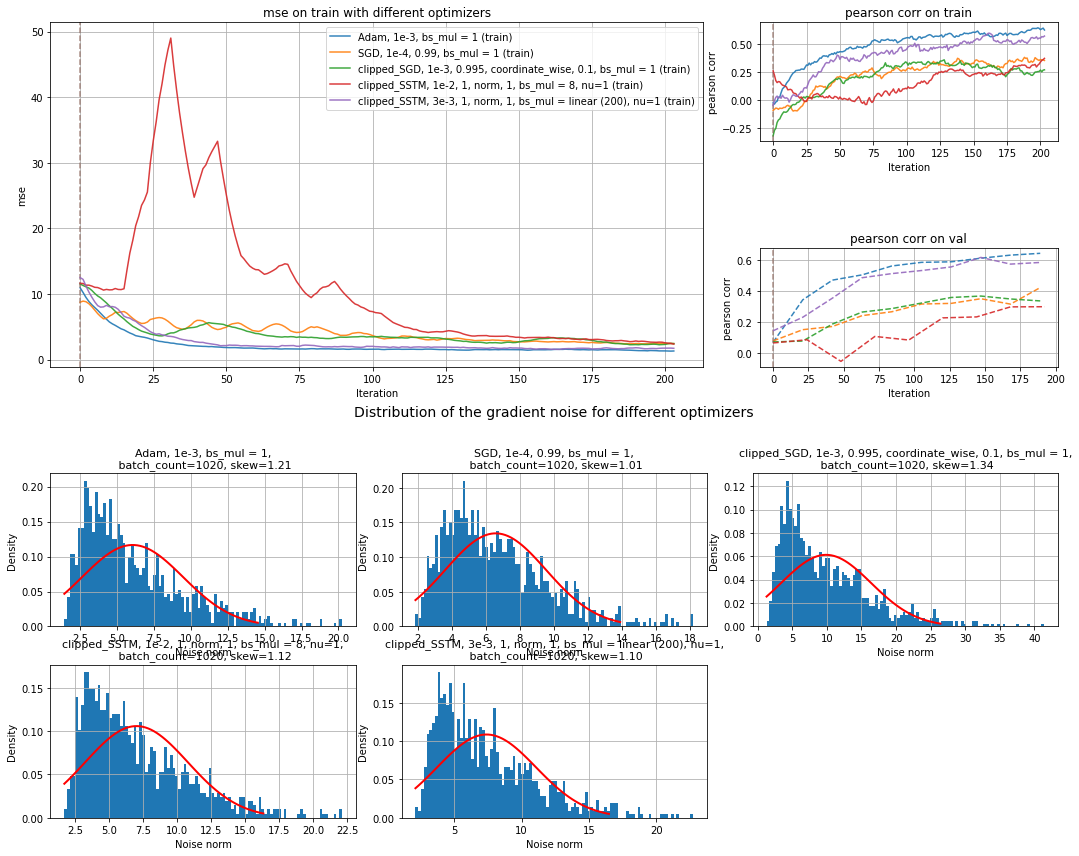

Computing full gradient


  0%|          | 0/204 [00:00<?, ?it/s]

In [ ]:
from IPython import display

# batch_mul_step_count = 50
calc_norm_diffs = True


for epoch in range(1):
    for (net, optimizer, net_hist) in zip(nets, opts, hist):
        net.to(device)
        optimizer_to(optimizer, device)

        total_steps = net_hist["total_steps"]
        # effective batch size will be batch_size * bs_mul
        bs_mul = net_hist["bs_mul"]
        # learning rate decay rate
        lr_decay = net_hist["lr_decay"]
        batch_mul_step_count = net_hist["batch_mul_step_count"]
            
        if net_hist["bs_mul"] == "linear":
            if not ("bs_mul_value" in net_hist):
                net_hist["bs_mul_value"] = 1

            bs_mul = net_hist["bs_mul_value"]
            
        net_hist["epochs_x"].append(total_steps)

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # compute norm diffs distribution on train dataset
            prev_grad_norms_eval_step = net_hist["prev_grad_norms_eval_step"]
            if calc_norm_diffs and ((total_steps - prev_grad_norms_eval_step) > 150 or len(net_hist["norm_diffs"]) == 0) and net_hist["batch_end"]:
                net_hist["prev_grad_norms_eval_step"] = total_steps
                net.eval()

                norm_diffs = compute_norm_diffs(
                    net, optimizer, None, 
                    train_loader_for_full_grad, train_loader, repeats=5
                )

                net_hist["norm_diffs"].append(norm_diffs)
                net_hist["norm_diffs_x"].append(total_steps)
                net.train()


            # evaluate on validation dataset
            prev_val_eval_step = net_hist["prev_val_eval_step"]
            if ((total_steps - prev_val_eval_step) > 20 or len(net_hist["val_loss"]) == 0) and net_hist["batch_end"]:
                net_hist["prev_val_eval_step"] = total_steps

                net.eval()

                val_losses = []
                val_metrics = dict((key, []) for key in metric_keys)
                
                with torch.no_grad():
                    for step, val_data in enumerate(val_loader):

                        inputs, masks, labels = val_data[0].to(device), val_data[1].to(device), val_data[2].to(device)

                        outputs = net(
                            inputs, 
                            token_type_ids=None, 
                            attention_mask=masks, 
                            labels=labels
                        )
                        loss = outputs[0]

                        val_losses.append(loss.detach().cpu().item())

#                         acc = accuracy(outputs.logits, labels.data, topk=(1,))
                        val_metrics_for_batch = compute_metrics((outputs[1], labels))
                        for key in val_metrics:
                            val_metrics[key].append(val_metrics_for_batch[key])
#                         val_accs.append(acc[0].detach().cpu().item())

                net_hist["val_loss"].append(np.mean(val_losses))
                net_hist["val_x"].append(total_steps)

                for key in val_metrics:
                    net_hist["val_{}".format(key)].append(np.mean(val_metrics[key]))

                net.train()

            net_hist["batch_end"] = False
            ######################################################################
            if lr_decay < 1:
                for g in optimizer.param_groups:
                    g['lr'] = g['lr'] * lr_decay
            ######################################################################
            
            # train
            inputs, masks, labels = data[0].to(device), data[1].to(device), data[2].to(device)

            outputs = net(
                inputs, 
                token_type_ids=None, 
                attention_mask=masks, 
                labels=labels
            )
            loss = outputs[0] / bs_mul
            loss.backward()

            if total_steps % bs_mul == bs_mul - 1:
                optimizer.step()
                optimizer.zero_grad()
                net_hist["batch_end"] = True

            net_hist["train_loss"].append(loss.detach().cpu().item() * bs_mul)
            net_hist["train_x"].append(total_steps)

            if total_steps % bs_mul == bs_mul - 1:
                if net_hist["bs_mul"] == "linear":
                    net_hist["bs_mul_value"] = int(int(total_steps) / batch_mul_step_count) + 1 
                    bs_mul = net_hist["bs_mul_value"]

#             top_1 = accuracy(outputs.logits, labels.data, topk=(1,))
#             net_hist["train_acc_top_1"].append(top_1[0].detach().cpu().item())
            train_metrics_for_batch = compute_metrics((outputs[1], labels))
            for key in train_metrics_for_batch:
                net_hist["train_{}".format(key)].append(train_metrics_for_batch[key])

            if total_steps % 10 == 0:
                display.clear_output(wait=True)
                
                grouped_hist = group_uniques_full(hist, ["train_loss", "val_loss", "val_pearson", "train_pearson"])

                fig = plt.figure(figsize=(15, 8 + 2 * ((len(grouped_hist) + 2) // 3)))
                gs = GridSpec(4 + 2 * ((len(grouped_hist) + 2) // 3),3, figure=fig)

                ax1 = fig.add_subplot(gs[0:4,:2])
                ax2 = fig.add_subplot(gs[0:2,2])
                ax3 = fig.add_subplot(gs[2:4,2])

                ax1 = make_loss_plot(ax1, grouped_hist, eps=0.1, make_val=False, alpha=0.9, loss_name="mse")
                ax2 = make_metrics_plot(ax2, grouped_hist, eps=0.1, make_train=True, make_val=False, alpha=0.9, metric_name="pearson", title="pearson corr")
                ax3 = make_metrics_plot(ax3, grouped_hist, eps=0.1, make_train=False, make_val=True, alpha=0.9, metric_name="pearson", title="pearson corr")
                
                if calc_norm_diffs:
                    draw_norm_hists_for_different_models(fig, gs[4:,:], grouped_hist, bins_n=100, draw_normal=True)

                gs.tight_layout(fig)
                plt.draw()
                plt.show()

            total_steps += 1
        net_hist["total_steps"] = total_steps
        net.to("cpu")
        optimizer_to(optimizer, "cpu")

print('Finished Training')

### Save models / train data

In [25]:
from datetime import datetime

now = datetime.now()
now = str(now)

In [26]:
save_net_weights = False


if save_net_weights:
    for i in range(len(nets)):
        if "/" in hist[i]["name"]:
            hist[i]["name"] = ":".join(hist[i]["name"].split("/"))
        PATH = './models/bert_{}.pth'.format(
            "_".join(now.split(" ")[0:1] + now.split(" ")[1].split(".")[0].split(":") + hist[i]["name"].split())
        )
        torch.save(nets[0].state_dict(), PATH)

In [27]:
from copy import deepcopy

hist3 = deepcopy(hist)

In [28]:
for h in hist3:
    for key in h:
        if isinstance(h[key], list) and  len(h[key])> 0 :
            if isinstance(h[key][0], torch.Tensor):
                for i in range(len(h[key])):
                    h[key][i] = h[key][i].numpy()
            if isinstance(h[key][0], np.ndarray):
                for i in range(len(h[key])):
                    if len(h[key][i]) == 1:
                        h[key][i] = np.asscalar(h[key][i])
                    else:
                        h[key][i] = [str(x) for x in h[key][i]]
            for i in range(len(h[key])):
                if not isinstance(h[key][i], list):
                    h[key][i] = str(h[key][i])

In [29]:
import json
import os

filename = './results/{}/stsb/bert_stsb_{}_train_hist.json'.format(data_folder_name,"_".join(now.split(" ")[0:1] + now.split(" ")[1].split(".")[0].split(":")))
          
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, 'w') as fout:
    json.dump(hist3 , fout)

### Averaged plots

In [ ]:
import json
hists_names_list = [
    "bert_stsb_2021-11-01_23_08_25_train_hist", # combined (ds-12, 12, 5, 15 epochs)
    "bert_stsb_2021-10-31_20_48_29_train_hist", # combined (ds-11, 11, 5, 15 epochs)
    "bert_stsb_2021-10-29_14_53_41_train_hist", # combined (ds-10, 10, 5, 15 epochs)
    "bert_stsb_2021-10-27_19_06_39_train_hist", # combined (ds-9, 9, 5, 15 epochs)
    "bert_stsb_2021-10-25_19_41_23_train_hist", # combined (ds-8, 8, 5, 15 epochs)
    "bert_stsb_2021-10-23_21_53_38_train_hist", # combined (ds-7, 7, 5, 15 epochs)
    "bert_stsb_2021-10-23_08_02_38_train_hist", # combined (ds-6, 6, 5, 15 epochs)
    "bert_stsb_2021-10-22_09_32_35_train_hist", # combined (ds-5, 5, 5, 15 epochs)
    "bert_stsb_2021-10-21_21_41_13_train_hist", # combined (ds-4, 4, 5, 15 epochs)
    "bert_stsb_2021-10-20_17_22_42_train_hist", # combined (ds-3, 3, 5, 15 epochs)
    "bert_stsb_2021-10-19_09_19_00_train_hist", # combined (ds-2, 2, 5, 15 epochs)
    "bert_stsb_2021-10-18_22_04_29_train_hist", # combined (ds-1, 1, 5, 15 epochs)
#     "bert_stsb_2021-10-12_09_05_42_train_hist",
#     "bert_stsb_2021-10-11_04_02_22_train_hist", # clipped_SSTM gridsearch (linear)
#     "bert_stsb_2021-10-18_01_41_29_train_hist",
#     "bert_stsb_2021-10-16_01_21_55_train_hist", # clipped_SSTM gridsearch
#     "bert_stsb_2021-10-15_10_25_59_train_hist", # clipped_SSTM gridsearch
#     "bert_stsb_2021-10-14_13_22_04_train_hist", # clipped_SSTM gridsearch
#     "bert_stsb_2021-10-14_00_12_49_train_hist", # clipped_SSTM gridsearch
#     "bert_stsb_2021-10-13_06_04_23_train_hist", # clipped_SSTM gridsearch
#     "bert_stsb_2021-10-09_11_52_33_train_hist", # clipped_SSTM gridsearch
#     "bert_stsb_2021-10-08_20_41_33_train_hist", # clipped_SSTM gridsearch
#     "bert_stsb_2021-10-08_00_48_52_train_hist", # clipped_SSTM gridsearch
#     "bert_stsb_2021-10-10_05_38_13_train_hist", # clipped_SGD gridsearch
#     "bert_stsb_2021-10-07_04_16_32_train_hist", # clipped_SGD gridsearch
#     "bert_stsb_2021-10-06_03_15_35_train_hist", # SGD lr gridsearch
#     "bert_stsb_2021-10-05_01_32_46_train_hist", # Adam lr gridsearch, modified_betas
#     "bert_stsb_2021-10-04_18_11_56_train_hist", # Adam lr gridsearch, modified_betas
#     "bert_stsb_2021-10-04_09_38_51_train_hist", # Adam lr gridsearch
#     "bert_stsb_2021-10-03_22_26_31_train_hist", # default start with norm diffs!
]

# hists_names_list = hists_names_list[::-1]


hist = hist_from_json(load_hist_jsons(hists_names_list, path="./results/glue_data/stsb/"))

In [4]:
grouped_hist = group_uniques_full(
    hist, 
    ["train_loss", "val_loss", "train_pearson", "val_pearson"], 
    verbose=True,
    group_norm_diffs=True
)

# grouped_hist = grouped_hist[0:4]

def key(h, alpha=0.01):
    return smooth(h["train_loss"], alpha)[-1]

grouped_hist = sorted(grouped_hist, key=key)

def select_top(grouped_hist, algos):
    res = dict([(name, None) for name in algos])
    for name in algos:
        for hist in grouped_hist:
            if name == hist["name"].split(",")[0]:
                res[name] = hist
                break
    return list(res.values())

# grouped_hist = select_top(grouped_hist, ["clipped_SSTM", "clipped_SGD", "SGD", "Adam"])

grouped_hist = grouped_hist[:5]

Repeats_1 = 15.0, Name = Adam, 1e-3, bs_mul = 1
Repeats_1 = 15.0, Name = SGD, 1e-4, 0.99, bs_mul = 1
Repeats_1 = 15.0, Name = clipped_SGD, 1e-3, 0.995, coordinate_wise, 0.1, bs_mul = 1
Repeats_1 = 15.0, Name = clipped_SSTM, 1e-2, 1, norm, 1, bs_mul = 8, nu=1
Repeats_1 = 15.0, Name = clipped_SSTM, 3e-3, 1, norm, 1, bs_mul = linear (200), nu=1


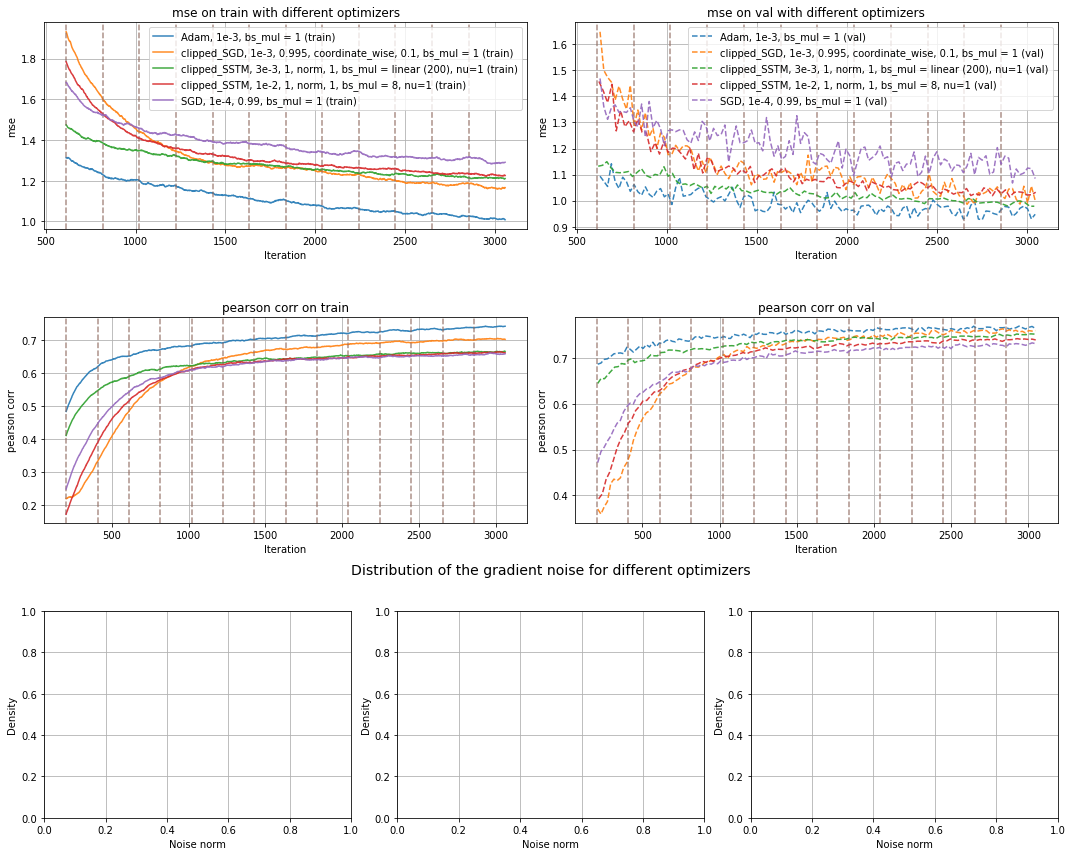

In [5]:
from IPython import display

fig = plt.figure(figsize=(15,12))
gs = GridSpec(3,2, figure=fig)


display.clear_output(wait=True)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])

# ax1 = make_loss_plot(ax1, grouped_hist, eps=0.01, make_val=False, alpha=0.9, starting_epoch=0)
# ax2 = make_loss_plot(ax2, grouped_hist, eps=0.01, make_train=False, alpha=0.9, starting_epoch=0)
# ax3 = make_accuracy_plot(ax3, grouped_hist, eps=0.01, make_train=True, make_val=False, top_k=1, alpha=0.9, starting_epoch=1)
# ax4 = make_accuracy_plot(ax4, grouped_hist, eps=0.01, make_train=False, make_val=True, top_k=1, alpha=0.9, starting_epoch=1)

eps = 0.01

ax1 = make_loss_plot(ax1, grouped_hist, eps=eps, make_val=False, alpha=0.9, loss_name="mse", starting_epoch=3)
ax2 = make_loss_plot(ax2, grouped_hist, eps=eps, make_train=False, alpha=0.9, loss_name="mse", starting_epoch=3)
ax3 = make_metrics_plot(ax3, grouped_hist, eps=eps, make_train=True, make_val=False, alpha=0.9, starting_epoch=1, metric_name="pearson", title="pearson corr")
ax4 = make_metrics_plot(ax4, grouped_hist, eps=eps, make_train=False, make_val=True, alpha=0.9, starting_epoch=1, metric_name="pearson", title="pearson corr")

grouped_hist_for_distrs = [grouped_hist[0], grouped_hist[1], grouped_hist[3]]

draw_norm_hists_for_different_models(fig, gs[2:,:], grouped_hist_for_distrs, bins_n=100, draw_normal=True, number=0)

gs.tight_layout(fig)
plt.draw()
plt.show()